# Iteratively apply g and learn params

In [1]:
from typing import List
import torch
import torch.nn as nn
from stabnode.node import MLP
from stabnode.utils import set_global_seed
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from data.budworm import simulate_trials, budworm_steady_states
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tqdm.auto import tqdm
device='cpu'
set_global_seed(1234)

In [2]:
k=8.5

## Generate data

In [3]:
# x = np.linspace(0,1,101)

## Generate more interesting data
k = 8.5

xs = []
ts = []
x0s = np.linspace(0.1,10,51)
for x0 in x0s:
    budworm_trial =simulate_trials([k],x0, dt=0.1,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501, show_progress=False)
    xs.append(budworm_trial.x_vals[0])
    ts.append(budworm_trial.t_vals[0])

In [4]:
scaler = MinMaxScaler()
scaler.fit(np.concatenate(xs).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

In [5]:
x_steady =budworm_steady_states(k,r=0.56)
x_steady_scaled = scaler.transform(np.array(x_steady).reshape(-1,1)).reshape(-1)

In [6]:
x_steady_scaled

array([0.08388006, 0.14210819, 0.60229458])

In [7]:
for idx, xi in enumerate(xs_scaled):
    print(f"{idx}: x0 = {xi[0]:.2f}, xs = {xi[-1]:.3f}")

0: x0 = 0.00, xs = 0.084
1: x0 = 0.02, xs = 0.084
2: x0 = 0.04, xs = 0.084
3: x0 = 0.06, xs = 0.084
4: x0 = 0.08, xs = 0.084
5: x0 = 0.10, xs = 0.084
6: x0 = 0.12, xs = 0.084
7: x0 = 0.14, xs = 0.084
8: x0 = 0.16, xs = 0.602
9: x0 = 0.18, xs = 0.602
10: x0 = 0.20, xs = 0.602
11: x0 = 0.22, xs = 0.602
12: x0 = 0.24, xs = 0.602
13: x0 = 0.26, xs = 0.602
14: x0 = 0.28, xs = 0.602
15: x0 = 0.30, xs = 0.602
16: x0 = 0.32, xs = 0.602
17: x0 = 0.34, xs = 0.602
18: x0 = 0.36, xs = 0.602
19: x0 = 0.38, xs = 0.602
20: x0 = 0.40, xs = 0.602
21: x0 = 0.42, xs = 0.602
22: x0 = 0.44, xs = 0.602
23: x0 = 0.46, xs = 0.602
24: x0 = 0.48, xs = 0.602
25: x0 = 0.50, xs = 0.602
26: x0 = 0.52, xs = 0.602
27: x0 = 0.54, xs = 0.602
28: x0 = 0.56, xs = 0.602
29: x0 = 0.58, xs = 0.602
30: x0 = 0.60, xs = 0.602
31: x0 = 0.62, xs = 0.602
32: x0 = 0.64, xs = 0.602
33: x0 = 0.66, xs = 0.602
34: x0 = 0.68, xs = 0.602
35: x0 = 0.70, xs = 0.602
36: x0 = 0.72, xs = 0.602
37: x0 = 0.74, xs = 0.602
38: x0 = 0.76, xs = 0.

In [8]:
class AsymDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials:List, k_vals: List):
        self.x_trials = x_trials     
        self.k_vals = k_vals                  

    def __len__(self):
        return len(self.x_trials) 

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {self.__len__()}."
            )
        
        
        Xi = self.x_trials[idx]   
        ki = self.k_vals[idx]                                       
        x0 = Xi[0]
        x_asym = Xi[-1]
        return x0, x_asym, ki

In [9]:
xs_torch = [torch.tensor(
    xi, dtype=torch.float32,device=device
) for xi in xs_scaled]

ks_torch = [
    torch.tensor(
        k, dtype=torch.float32,device=device
    ) for _ in xs_scaled
]



In [10]:
dataset = AsymDataset(xs_torch, ks_torch)
loader = torch.utils.data.DataLoader(
    dataset, shuffle=False, batch_size=1, num_workers=0
)

## Define $g$

In [11]:
from stabnode.node import GeluSigmoidMLPfeaturized

In [18]:
from data.budworm import g_true, f_true

x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()
x_lin_torch = torch.tensor(x_lin, dtype=torch.float32)


f_true_arr =  f_true(x_lin_unscaled)
g_true_arr = scaler.transform(g_true(x_lin_unscaled, k, r=0.56).reshape(-1,1)).squeeze()

In [13]:
g = GeluSigmoidMLPfeaturized(
    dims = [5,10,10,1], 
    activation = torch.nn.SiLU(), 
    lower_bound = g_true_arr.min(), 
    upper_bound = g_true_arr.max(), 
    freq_sample_step = 1,
    feat_lower_bound=0,
    feat_upper_bound=1
    )

In [14]:
iteration  = 100
lr = 1e-2
opt = torch.optim.Adam(g.parameters(), lr=lr)
loss_criteria = nn.MSELoss()
n_epochs = 100

g.train()

losses = []
for epoch in tqdm(range(n_epochs)):
    epoch_loss = 0.0
    batch_count = 0
    
    for x0, x1, ki in loader:
        opt.zero_grad()
        x = x0.detach()  # don't backprop into x0
        for _ in range(iteration):
            x = g(x, ki)
        loss = loss_criteria(x, x1)
        loss.backward()
        opt.step()
        
        epoch_loss += loss.item()
        batch_count += 1

    # average over number of batches
    epoch_loss /= batch_count
    losses.append(epoch_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss:.6e}")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Loss: 2.435146e-02
Epoch 10, Loss: 4.262079e-02
Epoch 20, Loss: 4.208210e-02
Epoch 30, Loss: 3.809964e-02
Epoch 40, Loss: 3.837158e-02
Epoch 50, Loss: 3.876836e-02
Epoch 60, Loss: 3.766498e-02
Epoch 70, Loss: 1.689941e-01
Epoch 80, Loss: 1.689941e-01
Epoch 90, Loss: 1.689941e-01


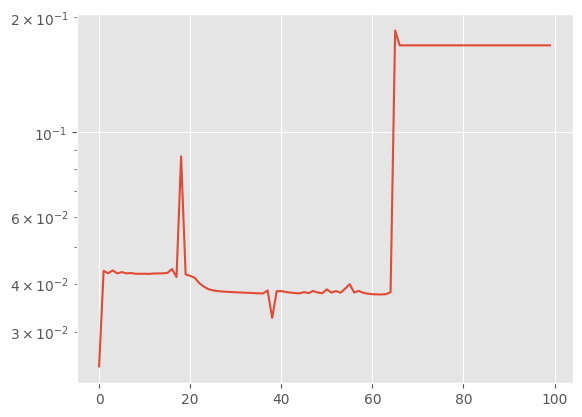

In [15]:
plt.plot(losses)
plt.yscale('log')

# Plot method

In [19]:
g_eval = g.eval()

with torch.no_grad():
    
    k_torch = torch.tensor(k,dtype=torch.float32).reshape(-1,1)
    g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])
    # ax1.plot(x_lin_torch, g_pred, label=rf'$\alpha$={alpha}', linestyle='--', alpha=1, lw=3)

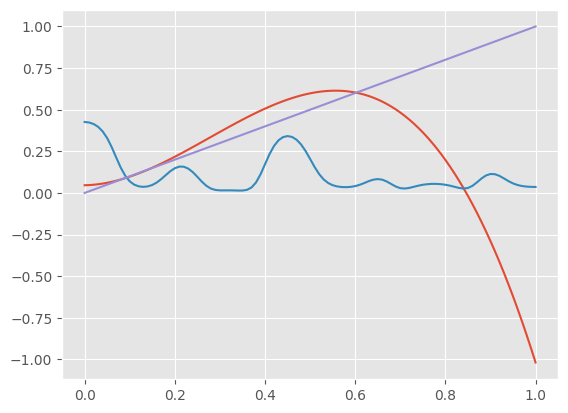

In [21]:
plt.plot(x_lin, g_true_arr)
plt.plot(x_lin, g_pred)
plt.plot(x_lin,x_lin)